# Optimization Algorithm Evaluation

 * Evaluate the performance and cost optimization algorithm on a serverless application with 6 functions and 4 types of structures

In [1]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle

## Performance Profile

In [2]:
OptAlg_lambda_logs = pd.read_csv('../profile-functions/OptAlg_lambda_logs.csv', low_memory=False)
OptAlg_lambda_logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTCTimestamp', 'RequestId']

In [3]:
OptAlg_lambda_logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,UTCTimestamp,RequestId
0,f1,128,36,2770.56,2771,1.642830e+09,4603b28c-f1f6-476e-977b-c146a5ce5b32
1,f1,128,36,2781.87,2782,1.642830e+09,4150ee72-565d-4635-a05a-0dd24d0660de
2,f1,128,36,2728.25,2729,1.642830e+09,fd95be12-1294-4dd3-9e57-4b48512bcf17
3,f1,128,36,2756.99,2757,1.642830e+09,93b159e6-3c1a-4fb8-867e-d4d726abffed
4,f1,128,36,2710.97,2711,1.642830e+09,53089722-fd5c-41fe-adb3-a73277c95642


In [4]:
viable_mem_list = list(range(128, 1024, 64)) + list(range(1024, 2048, 128)) + list(range(2048, 4096, 256)) + list(range(4096, 10240 + 512, 512))

In [5]:
performance_profile = {}
for i in range(6):
    dic = {}
    for mem in viable_mem_list:
        dic[mem] = np.array(
            OptAlg_lambda_logs.query(f"Function == 'f{i + 1}' and Memory_Size == {mem} ")['Duration'].tolist()[10:190])
    performance_profile[f"f{i + 1}"] = dic

## Application Definition

In [6]:
import sys
sys.path.append('../../')
from slappsim.Structures import *
from slappsim.Function import *
from slappsim.PetriApp import *
from slappsim.States import *
from slapptuner.AppTuner import AppTuner

In [7]:
from functools import partial

In [8]:
rs = np.random.RandomState(64)
random.seed(64)

In [9]:
scheduling_overhead = pd.read_csv('../../modeling/sfn-delay/Scheduling_Overhead.csv')
scheduling_overhead = np.array(scheduling_overhead['scheduling_overhead'].to_list())
function_execution_delay = pd.read_csv('../../modeling/sfn-delay/Function_Execution_Delay.csv')
function_execution_delay = np.array(function_execution_delay['Duration'].to_list())
sfn_scheduling_overhead_fun = partial(rs.choice, a=scheduling_overhead)
function_execution_delay_fun = partial(rs.choice, a=function_execution_delay)
delays = {'FunctionExecution': function_execution_delay_fun, 'SchedulingOverhead': sfn_scheduling_overhead_fun}

In [10]:
def dummy_fun():
    return 0
dummy_pf_fun = partial(dummy_fun)

In [11]:
start = Start()
end = End()
f1 = Function(pf_fun=dummy_pf_fun, mem=0, name='f1')
f2 = Function(pf_fun=dummy_pf_fun, mem=0, name='f2')
f3 = Function(pf_fun=dummy_pf_fun, mem=0, name='f3')
f4 = Function(pf_fun=dummy_pf_fun, mem=0, name='f4')
f5 = Function(pf_fun=dummy_pf_fun, mem=0, name='f5')
f6 = Function(pf_fun=dummy_pf_fun, mem=0, name='f6')
choice1 = Choice(choices=[f3, f5], probabilities=[0.8, 0.2])
parallel_sequence1 = Sequence(actions=[choice1])
parallel_sequence2 = Sequence(actions=[f2])
parallel1 = Parallel(branches=[parallel_sequence1, parallel_sequence2])
map_sequence = Sequence(actions=[f6])
map1 = Map(sequence=map_sequence, iterations=10, maximum_concurrency=0)
rchoice1 = Choice(choices=[f1, f4, map1], probabilities=[0.1, 0.2, 0.7], end=False)
sequence1 = Sequence(actions=[f1, parallel1, f4, rchoice1, map1])
structures = [parallel1, choice1, rchoice1, sequence1, parallel_sequence1, parallel_sequence2, map1]
i1 = InArc(place=start)
o1 = OutArc(place=sequence1.structure_start)
t1 = Transition(in_arcs=[i1], out_arcs=[o1])
i2 = InArc(place=sequence1.structure_end)
o2 = OutArc(place=end)
t2 = Transition(in_arcs=[i2], out_arcs=[o2])
transitions = [t1, t2]
transitions += sequence1.transitions
app = PetriApp(transitions=transitions, functions=[f1, f2, f3, f4, f5, f6], structures=structures, delays=delays)


In [12]:
tuner_app = AppTuner(petri_model=app, performance_profile=performance_profile)

In [13]:
tuner_app.initialize_with_minimum_cost_configuration()
tuner_app.profile_multiprocessing(k=10000)
minimum_cost_avg = np.mean(tuner_app.cost_list) * 1000000
minimum_cost_percentile_90 = np.percentile(tuner_app.cost_list, 90) * 1000000
tuner_app.initialize_with_maximum_cost_configuration()
tuner_app.profile_multiprocessing(k=10000)
maximum_cost_avg = np.mean(tuner_app.cost_list) * 1000000
maximum_cost_percentile_90 = np.percentile(tuner_app.cost_list, 90) * 1000000
tuner_app.initialize_with_best_performance_configuration()
tuner_app.profile_multiprocessing(k=10000)
minimum_duration_avg = np.mean(tuner_app.ert_list)
minimum_duration_percentile_90 = np.percentile(tuner_app.ert_list, 90)
tuner_app.initialize_with_worst_performance_configuration()
tuner_app.profile_multiprocessing(k=10000)
maximum_duration_avg = np.mean(tuner_app.ert_list)
maximum_duration_percentile_90 = np.percentile(tuner_app.ert_list, 90)

In [14]:
task_count = 100

## BPBC

In [15]:
%%capture
os.mkdir("BPBC")
for constraint in np.linspace(165, 265, task_count):
    result = {}
    result['problem'] = 'BPBC'
    result['constraint'] = constraint
    result['percentile'] = None 
    configuration = tuner_app.optimize_bpbc(budget_constraint = constraint, percentile = None)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BPBC/{round(constraint, 2)}_avg.json", 'w') as f:
        json.dump(result, f)

for constraint in np.linspace(179, 279, task_count):
    result = {}
    result['problem'] = 'BPBC'
    result['constraint'] = constraint
    result['percentile'] = 90
    configuration = tuner_app.optimize_bpbc(budget_constraint = constraint, percentile = 90)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BPBC/{round(constraint, 2)}_percentile90.json", 'w') as f:
        json.dump(result, f)

## BCPC

In [ ]:
%%capture
os.mkdir("BCPC")
for constraint in np.linspace(1611, 3611, task_count):
    result = {}
    result['problem'] = 'BCPC'
    result['constraint'] = constraint
    result['percentile'] = None
    configuration = tuner_app.optimize_bcpc(performance_constraint = constraint, percentile = None)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BCPC/{round(constraint, 2)}_avg.json", 'w') as f:
        json.dump(result, f)
        
for constraint in np.linspace(2151, 4151, task_count):
    result = {}
    result['problem'] = 'BCPC'
    result['constraint'] = constraint
    result['percentile'] = 90
    configuration = tuner_app.optimize_bcpc(performance_constraint = constraint, percentile = 90)
    result['optimized_configuration'] = configuration
    result['duration'] = tuner_app.ert_list.tolist()
    result['cost'] = tuner_app.cost_list.tolist()
    with open(f"./BCPC/{round(constraint, 2)}_percentile90.json", 'w') as f:
        json.dump(result, f)

## Results

In [14]:
optimization_results = pd.DataFrame(columns=["problem", "constraint", "percentile", "optimized_configuration", "duration_avg", "duration_median", "duration_percentile10", "duration_percentile90", "cost_avg", "cost_median", "cost_percentile10", "cost_percentile90"])

In [15]:
for file in os.listdir("BPBC"):
    with open(f"BPBC/{file}" , "r") as f:
        result_dict = {}
        result = json.load(f)
        result["duration_avg"] = np.mean(result['duration'])
        result["duration_median"] = np.median(result['duration'])
        result["duration_percentile10"] = np.percentile(result['duration'], 10)
        result["duration_percentile90"] = np.percentile(result['duration'], 90)
        result["cost_avg"] = np.mean(result['cost']) * 1000000
        result["cost_median"] = np.median(result['cost']) * 1000000
        result["cost_percentile10"] = np.percentile(result['cost'], 10) * 1000000
        result["cost_percentile90"] = np.percentile(result['cost'], 90) * 1000000
        result.pop("duration")
        result.pop("cost")
        optimization_results = optimization_results.append(result, ignore_index=True)

for file in os.listdir("BCPC"):
    with open(f"BCPC/{file}" , "r") as f:
        result_dict = {}
        result = json.load(f)
        result["duration_avg"] = np.mean(result['duration'])
        result["duration_median"] = np.median(result['duration'])
        result["duration_percentile10"] = np.percentile(result['duration'], 10)
        result["duration_percentile90"] = np.percentile(result['duration'], 90)
        result["cost_avg"] = np.mean(result['cost']) * 1000000
        result["cost_median"] = np.median(result['cost']) * 1000000
        result["cost_percentile10"] = np.percentile(result['cost'], 10) * 1000000
        result["cost_percentile90"] = np.percentile(result['cost'], 90) * 1000000
        result.pop("duration")
        result.pop("cost")
        optimization_results = optimization_results.append(result, ignore_index=True)

In [16]:
optimization_results.head()

,problem,constraint,percentile,optimized_configuration,duration_avg,duration_median,duration_percentile10,duration_percentile90,cost_avg,cost_median,cost_percentile10,cost_percentile90
0,BPBC,189.204082,90,"{'f1': 1920, 'f2': 1792, 'f3': 832, 'f4': 1152...",1903.149779,1799.694790,1168.795874,2609.288993,171.135456,167.551371,162.446153,188.721308
1,BPBC,272.877551,90,"{'f1': 2560, 'f2': 2304, 'f3': 2560, 'f4': 358...",1631.568744,1539.194864,1064.814030,2239.502244,237.280004,229.579620,219.441267,270.674701
2,BPBC,225.938776,90,"{'f1': 2048, 'f2': 1792, 'f3': 2560, 'f4': 204...",1643.923336,1556.089807,1083.400151,2193.336151,205.505078,202.933734,181.717025,224.942943
3,BPBC,199.693878,None,"{'f1': 2560, 'f2': 2304, 'f3': 2560, 'f4': 358...",1638.888903,1545.664970,1072.117786,2260.739065,198.711624,190.887876,180.716606,232.887125
4,BPBC,252.755102,None,"{'f1': 2560, 'f2': 1792, 'f3': 2560, 'f4': 768...",1627.613540,1533.789771,1060.848128,2227.330523,252.225596,241.017143,222.725023,299.049341


In [17]:
optimization_results.shape

(200, 12)

### BPBC

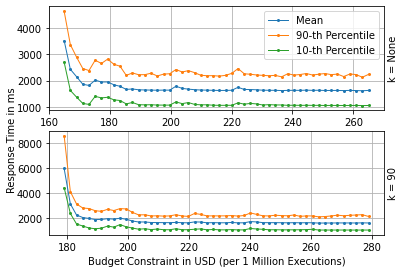

In [140]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 4.2))
results = optimization_results.query("problem=='BPBC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='10-th Percentile', markersize=2, linewidth=1)
ax1.legend()
ax1.grid()
plt.xlabel('Budget Constraint in USD (per 1 Million Executions)')
fig.text(0.04, 0.44, 'Response Time in ms', va='center', ha='center', rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("k = None")

ax2.yaxis.set_label_position("right")
ax2.set_ylabel("k = 90")
results = optimization_results.query("problem=='BPBC' and percentile.notnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='10-th Percentile', markersize=2, linewidth=1)
ax2.grid()

plt.show()
fig.tight_layout(rect=[0.04, 0, 1, 1])
fig.savefig("DFBA-BPBC.pdf")

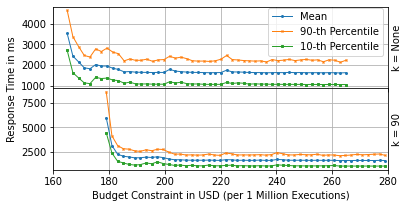

In [260]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)
results = optimization_results.query("problem=='BPBC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax1.plot(constraint_list, result_list, marker='x', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax1.plot(constraint_list, result_list, marker='s', label='10-th Percentile', markersize=2, linewidth=1)
ax1.set_xlim(160, 280)
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1.05))
ax1.grid()
# remove x labels
ax1.set_xticklabels([])
plt.xlabel('Budget Constraint in USD (per 1 Million Executions)')
fig.text(0.03, 0.5, 'Response Time in ms', va='center', ha='center', rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("k = None")

ax2.yaxis.set_label_position("right")
ax2.set_ylabel("k = 90")
ax2.set_xlim(160, 280)
results = optimization_results.query("problem=='BPBC' and percentile.notnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['duration_avg'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['duration_percentile90'].to_list()
ax2.plot(constraint_list, result_list, marker='x', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['duration_percentile10'].to_list()
ax2.plot(constraint_list, result_list, marker='s', label='10-th Percentile', markersize=2, linewidth=1)
ax2.grid()

# fig.tight_layout(rect=[0.04, 0, 1, 1])
plt.show()
fig.savefig("DFBA-BPBC.pdf", bbox_inches="tight")

### BCPC

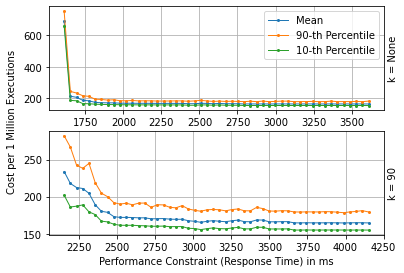

In [247]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 4.2))
results = optimization_results.query("problem=='BCPC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['cost_avg'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()
ax1.plot(constraint_list, result_list, marker='o', label='10-th Percentile', markersize=2, linewidth=1)
ax1.legend()
ax1.grid()
plt.xlabel('Performance Constraint (Response Time) in ms')
fig.text(0.04, 0.5, 'Cost per 1 Million Executions', va='center', ha='center', rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("k = None")

ax2.yaxis.set_label_position("right")
ax2.set_ylabel("k = 90")
results = optimization_results.query("problem=='BCPC' and percentile.notnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['cost_avg'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='10-th Percentile', markersize=2, linewidth=1)
ax2.grid()

plt.show()
fig.tight_layout(rect=[0.04, 0, 1, 1])
fig.savefig("DFBA-BCPC.pdf")

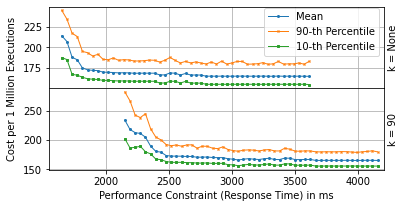

In [261]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)
results = optimization_results.query("problem=='BCPC' and percentile.isnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()[1:]
result_list = results['cost_avg'].to_list()[1:]
ax1.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()[1:]
ax1.plot(constraint_list, result_list, marker='x', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()[1:]
ax1.plot(constraint_list, result_list, marker='s', label='10-th Percentile', markersize=2, linewidth=1)
ax1.set_xlim(1550, 4200)
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1.05))
ax1.grid()
# remove x labels
ax1.set_xticklabels([])
plt.xlabel('Performance Constraint (Response Time) in ms')
fig.text(0.04, 0.5, 'Cost per 1 Million Executions', va='center', ha='center', rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("k = None")

ax2.yaxis.set_label_position("right")
ax2.set_ylabel("k = 90")
results = optimization_results.query("problem=='BCPC' and percentile.notnull()").sort_values(by='constraint')
constraint_list = results['constraint'].to_list()
result_list = results['cost_avg'].to_list()
ax2.plot(constraint_list, result_list, marker='o', label='Mean', markersize=2, linewidth=1)
result_list = results['cost_percentile90'].to_list()
ax2.plot(constraint_list, result_list, marker='x', label='90-th Percentile', markersize=2, linewidth=1)
result_list = results['cost_percentile10'].to_list()
ax2.plot(constraint_list, result_list, marker='s', label='10-th Percentile', markersize=2, linewidth=1)
ax2.set_xlim(1550, 4200)
ax2.grid()

plt.show()
#fig.tight_layout(rect=[0.04, 0, 1, 1])
fig.savefig("DFBA-BCPC.pdf", bbox_inches="tight")